In [1]:
import sys, os
project_root = "/home/shuol/final-project-group"
if project_root not in sys.path:
    sys.path.append(project_root)
import numpy as np
import matplotlib.pyplot as plt
import time

from src.Problems.lasso import LassoProblem
from src.Problems.total_var import TotalVariationProblem
from src.Problems.logistic import LogisticProblem
from src.Problems.huber_comp import HuberCompositeProblem

from src.Method.prox_gradient import ProxGradient
from src.Method.fista import FISTA
from src.Method.sfista import SmoothedFISTA
from src.Method.fdpg import FDPG
from src.Method.adlpmm import ADLPMM
from src.Method.prox_subgradient import ProxSubgradient
from src.Method.comd import CoMirrorDescent

In [2]:
def lasso_objective(problem, x, lam):
    """
    Compute the full LASSO objective: F(x) = f(x) + lam * g(x)
    """
    return float(problem.f(x) + lam * problem.g(x))

def soft_thresh(v, t):
    """ 
    Soft-thresholding operator with threshold t >= 0:S_t(v) = sign(v) * max(|v| - t, 0)
    """
    return np.sign(v) * np.maximum(np.abs(v) - t, 0)

def lasso_coordinate_descent(A, y, lam, max_iters=10000, tol=1e-10):
    """
    Coordinate descent for LASSO, solver, provides reference of optimizer.
    """
    m, n = A.shape
    x = np.zeros(n)
    # Precompute A^T A and A^T y for efficiency.
    AtA = A.T @ A
    Aty = A.T @ y
    diag = np.diag(AtA)

    for _ in range(max_iters):
        x_old = x.copy()
        for j in range(n):
            if diag[j] == 0:
                continue
            # coordinate update
            rho = Aty[j] - (AtA[j] @ x - diag[j] * x[j])
            x[j] = soft_thresh(rho / diag[j], lam / diag[j])

        if np.linalg.norm(x - x_old) < tol:
            break
    return x

In [3]:
def estimate_L(A):
    """
    Estimate L = ||A^T A||_2 using power iteration.
    This is used to choose a stable step size alpha = 1 / L for ProxGradient and FISTA.
    """
    # power iteration for spectral norm
    x = np.random.randn(A.shape[1])
    for _ in range(50):
        x = A.T @ (A @ x)
        x /= np.linalg.norm(x)
    L = np.linalg.norm(A @ x)**2
    return L

In [4]:
def make_lasso(m, n, sparsity, noise=0.05, seed=0, ill=False, orthonormal=False):
    """LASSO problem generator
    We generate three types of problems:
    - small well-conditioned
    - ill-conditioned
    - high-dimensional (n >> m)
    """
    rng = np.random.default_rng(seed)

    if orthonormal:
        Q, _ = np.linalg.qr(rng.standard_normal((m, m)))
        A = Q[:, :n]
    else:
        A = rng.standard_normal((m, n))
        if ill:
            scales = np.logspace(0, 3, n)
            A = A @ np.diag(1/scales)

        # normalize columns
        col_norms = np.linalg.norm(A, axis=0)
        col_norms[col_norms == 0] = 1
        A = A / col_norms

    # sparse truth
    x_true = np.zeros(n)
    idx = rng.choice(n, sparsity, replace=False)
    x_true[idx] = rng.normal(scale=3, size=sparsity)
    y = A @ x_true + noise * rng.standard_normal(m)
    return A, y, x_true

In [5]:
lam = 0.1
problems = [
    ("Small well-conditioned",
     dict(m=80, n=40, sparsity=10, ill=False, orthonormal=False, seed=0)),

    ("Ill-conditioned",
     dict(m=200, n=200, sparsity=20, ill=True, orthonormal=False, seed=1)),

    ("High-dimensional (n >> m)",
     dict(m=100, n=1000, sparsity=50, ill=False, orthonormal=False, seed=2)),]

In [6]:
def run_solver(solver, problem, lam, K):
    """Run a solver for K iterations and track objective values.
    """
    obj = []
    t0 = time.time()

    for _ in range(K):
        solver.step()
        obj.append(lasso_objective(problem, solver.x, lam))

    t1 = time.time()
    return np.array(obj), (t1 - t0)


Problem: Small well-conditioned
Reference objective F*: 3.143793e-01


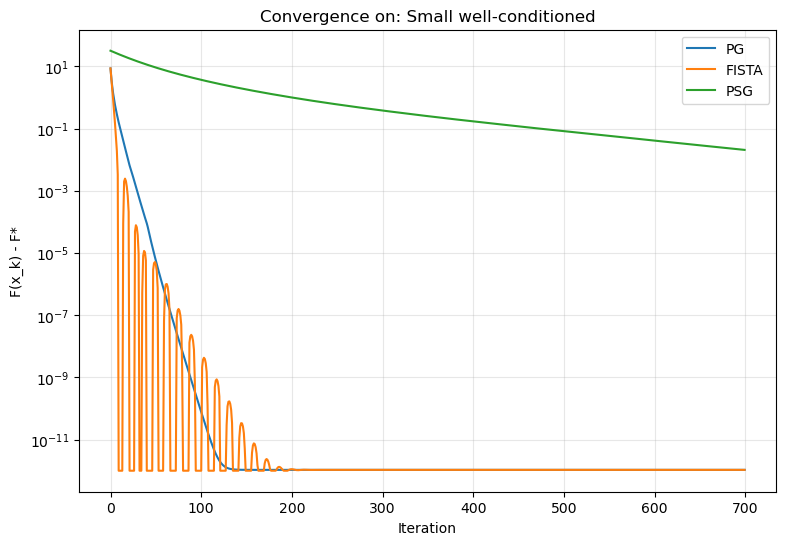

Timing:
  PG      : 0.0348 s
  FISTA   : 0.0210 s
  PSG     : 0.0237 s

Problem: Ill-conditioned
Reference objective F*: 7.325680e-01


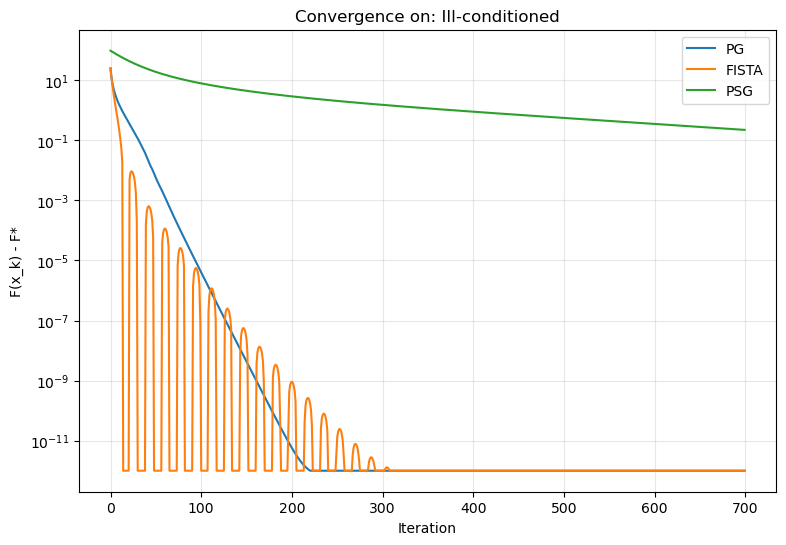

Timing:
  PG      : 0.0395 s
  FISTA   : 0.0420 s
  PSG     : 0.0500 s

Problem: High-dimensional (n >> m)
Reference objective F*: 1.323059e+00


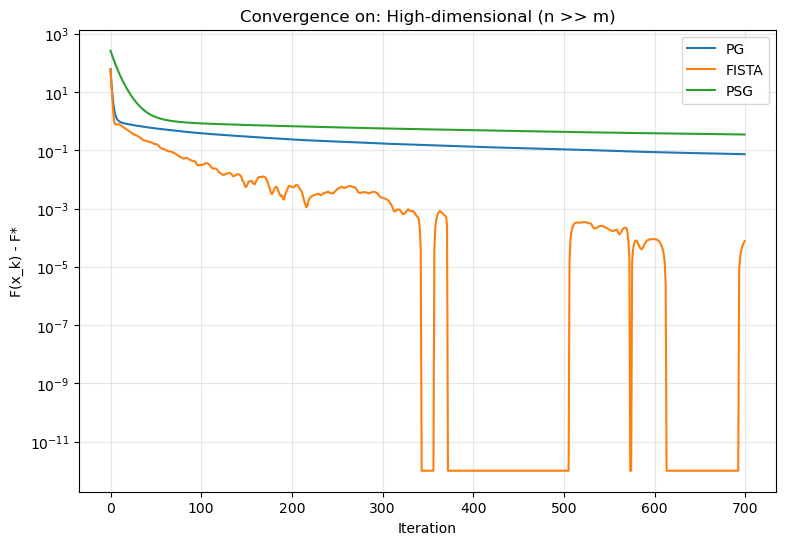

Timing:
  PG      : 0.0819 s
  FISTA   : 0.0717 s
  PSG     : 0.0772 s


In [9]:
results = {}
K = 700

for name, cfg in problems:
    print("\n==============================")
    print(f"Problem: {name}")
    print("==============================")

    m, n = cfg["m"], cfg["n"]
    sparsity = cfg["sparsity"]

    # generate problem 
    A, y, xt = make_lasso(m=cfg["m"],n=cfg["n"],sparsity=cfg["sparsity"],noise=0.05,seed=cfg["seed"],ill=cfg["ill"],orthonormal=cfg["orthonormal"])
    problem = LassoProblem(A, y, lam)

    # high accuracy optimizer
    x_ref = lasso_coordinate_descent(A, y, lam)
    F_star = lasso_objective(problem, x_ref, lam)
    print(f"Reference objective F*: {F_star:.6e}")

    # Lipschitz estimate
    L_est = estimate_L(A)
    alpha = 1 / (L_est + 1e-12)
    
    # initialize solvers
    pg_solver = ProxGradient(problem, x0=np.zeros(n), alpha=alpha)
    fista_solver = FISTA(problem, x0=np.zeros(n), alpha=alpha)
    psg_solver = ProxSubgradient(problem, x0=np.zeros(n),step_rule=lambda k: 1e-2/np.sqrt(k+1))

    # run solvers
    history = {}
    timing = {}

    history["PG"], timing["PG"] = run_solver(pg_solver, problem, lam, K)
    history["FISTA"], timing["FISTA"] = run_solver(fista_solver, problem, lam, K)
    history["PSG"], timing["PSG"] = run_solver(psg_solver, problem, lam, K)
    results[name] = (history, F_star, timing)

    plt.figure(figsize=(9,6))
    for method, vals in history.items():
        # clip for nicer plots
        vals_plot = np.maximum(vals - F_star + 1e-12, 1e-12)
        plt.plot(vals_plot, label=method)
    
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("F(x_k) - F*")
    plt.title(f"Convergence on: {name}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    
    # timing
    print("Timing:")
    for method, t in timing.items():
        if t is not None:
            print(f"  {method:8s}: {t:.4f} s")
